# Envenenamiento

## Instalación

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip uninstall tensorflow -y
!pip install tensorflow==1.9.0

Uninstalling tensorflow-1.15.2:
  Successfully uninstalled tensorflow-1.15.2
     |████████████████████████████████| 51.1MB 76kB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 
     |████████████████████████████████| 573kB 43.2MB/s 
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.9.0 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: google-auth 1.17.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: 

In [3]:
!pip install adversarial-robustness-toolbox==1.4.1
!pip install keras==2.2.4

     |████████████████████████████████| 768kB 2.8MB/s 
     |████████████████████████████████| 7.1MB 15.4MB/s 
     |████████████████████████████████| 21.0MB 1.6MB/s 
     |████████████████████████████████| 235kB 42.5MB/s 
     |████████████████████████████████| 747kB 42.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [4]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt


from art.utils import load_mnist, preprocess

Using TensorFlow backend.


In [5]:
%matplotlib inline

## Envenenar datos

In [6]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import preprocess
from art.defences.transformer.poisoning import NeuralCleanse

In [7]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

In [8]:
max_val = np.max(x_raw)
def poison_func(x):
        return add_pattern_bd(x, pixel_value=max_val)

In [9]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.arange(10) # 0, 1, 2, 3, ...
    targets = (np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    return is_poison, x_poison, y_poison

In [10]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, poison_func)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, poison_func)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Entrenar modelo

In [11]:
from art.estimators.classification import KerasClassifier

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Epoch 1/3
87/87 [==============================] - 41s 476ms/step - loss: 1.2479 - acc: 0.5519
Epoch 2/3
87/87 [==============================] - 41s 471ms/step - loss: 0.4129 - acc: 0.8685
Epoch 3/3
87/87 [==============================] - 41s 471ms/step - loss: 0.2527 - acc: 0.9250


In [13]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("Clean test set accuracy: {:.2f}%".format(clean_acc * 100))

poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("Effectiveness of poison: {:.2f}%".format(poison_acc * 100))

Clean test set accuracy: 96.58%
Effectiveness of poison: 95.05%


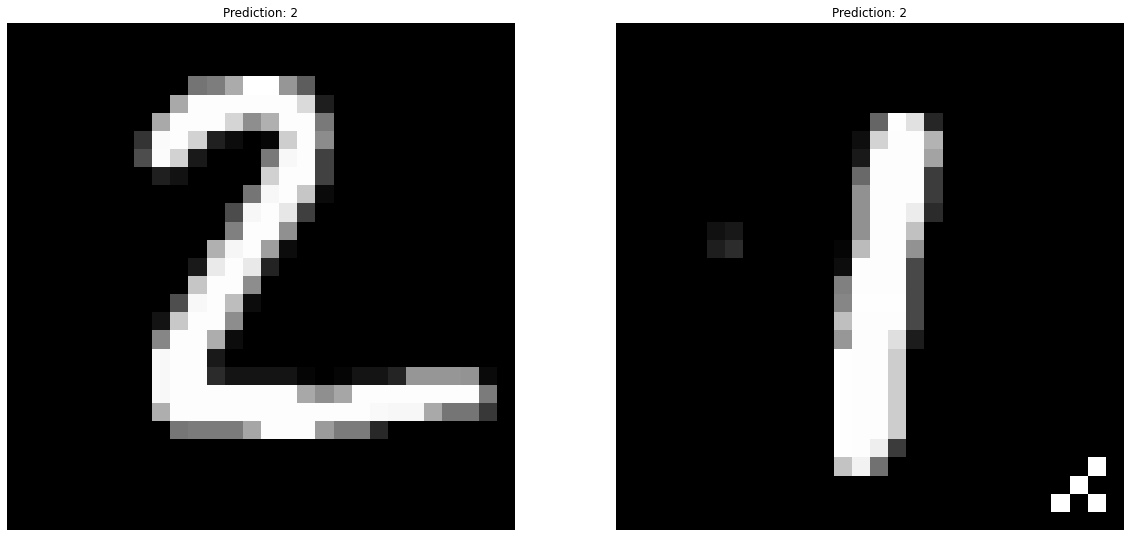

In [14]:
# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 2 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays
c_idx_p = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_x_test[c_idx].reshape((28, 28)), cmap="gray")
ax.axis('off')
ax.set_title("Prediction: {}".format(clean_preds[c_idx]))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(poison_x_test[c_idx_p].reshape((28, 28)), cmap="gray")
ax.axis('off')
ax.set_title("Prediction: {}".format(poison_preds[c_idx_p]))
plt.show()

## Detectar puerta trasera

In [15]:
cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)

Generating backdoor for class 1: 100%|██████████| 10/10 [06:25<00:00, 38.59s/it]


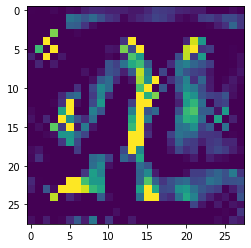

In [16]:
pattern, mask = defence_cleanse.generate_backdoor(x_test, y_test, np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
plt.imshow(np.squeeze(mask * pattern))

## Mitigación

In [17]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [04:21<00:00, 26.11s/it]


In [18]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 1041/4925 poison samples (21.14% effective)


In [19]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["unlearning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [04:16<00:00, 25.66s/it]

Epoch 1/1
   3/3147 [..............................] - ETA: 1:44 - loss: 0.0017 - acc: 1.0000

3147/3147 [==============================] - 87s 28ms/step - loss: 0.0095 - acc: 0.9971


In [20]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after unlearning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after unlearning: 31.47% (previously 95.05%)

 Clean test set accuracy: 37.60% (previously 96.58%)


In [21]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [04:11<00:00, 25.16s/it]


In [22]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 28.45% (previously 95.05%)

 Clean test set accuracy: 18.90% (previously 96.58%)


In [23]:
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning", "filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [04:11<00:00, 25.18s/it]
